Assignment:4
1. You have to create one supervisor node.
2. create one router function
3. create three more node 
   3.1 llm call (llm node)
   3.2 RAG (rag node)
   3.3 web crawler(fetch the info in realtime from internet)
4. created one more node after this for validation for generated output --> explore the validation part how to do that
5. if validation going to be failed in that case again go to supervioser node and then supervisor node will again decide what needs to be call next
6. once the validation will pass then only generate the final output

In [127]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

GOOGLE_GEMINI_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [128]:
if GOOGLE_GEMINI_API_KEY and TAVILY_API_KEY:
    print("API keys loaded successfully!")
else:
    print("Error: Missing API keys. Please check your .env file.")

API keys loaded successfully!


### Configure the model

In [129]:
# Loading the model
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model='gemini-1.5-flash')
output = model.invoke("Hi")
output

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--f7fd36ca-bed7-4384-817a-61932c6233c5-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

### Configure the Embedding Model

In [130]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name = "BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

384

### Load the data and embed the document

In [4]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

FILE_PATH = "/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/data/science.pdf"  # Change this to your PDF path
loader = PyPDFLoader(FILE_PATH)
docs = loader.load()

In [5]:
docs

[Document(metadata={'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationdate': '', 'moddate': '2025-06-13T05:37:33+00:00', 'source': '/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/data/science.pdf', 'total_pages': 272, 'page': 0, 'page_label': '1'}, page_content='Textbook of Science for Grade 6\nCuriosity\n0 Prelims.indd   1 23/12/2024   16:06:53\nReprint 2025-26'),
 Document(metadata={'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationdate': '', 'moddate': '2025-06-13T05:37:33+00:00', 'source': '/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/data/science.pdf', 'total_pages': 272, 'page': 1, 'page_label': '2'}, page_content='First Edition\nJuly 2024 Jyeshtha 1946\nReprint\nDecember 2024 Pausha 1946\nPD 2200T GS\n© National Council of Educational \nResearch and Training, 2024\n 65.00\nPrinted on 80 GSM paper with NCERT \nwatermark\nPublished at the Publication Division \nby the Secretary, National Council of \nEducational Research and Traini

In [7]:
text_splitter=RecursiveCharacterTextSplitter(chunk_size=800,chunk_overlap=50)
new_docs = text_splitter.split_documents(docs)
new_docs

db=Chroma.from_documents(new_docs,embeddings)
retriever=db.as_retriever(search_kwargs={"k": 3})

In [8]:
retriever.invoke("industrial growth of usa?")

[Document(metadata={'producer': 'iLovePDF', 'page_label': '166', 'creationdate': '', 'moddate': '2025-06-13T05:37:33+00:00', 'creator': 'PyPDF', 'source': '/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/data/science.pdf', 'page': 165, 'total_pages': 272}, page_content='the digital weighing balance. Will it increase or decrease or \nremain the same? \nDew drops on plants\nChapter 8.indd   148 10/4/2024   3:12:01 PM\nReprint 2025-26'),
 Document(metadata={'total_pages': 272, 'page_label': '166', 'page': 165, 'creationdate': '', 'moddate': '2025-06-13T05:37:33+00:00', 'creator': 'PyPDF', 'source': '/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/data/science.pdf', 'producer': 'iLovePDF'}, page_content='the digital weighing balance. Will it increase or decrease or \nremain the same? \nDew drops on plants\nChapter 8.indd   148 10/4/2024   3:12:01 PM\nReprint 2025-26'),
 Document(metadata={'moddate': '2025-06-13T05:37:33+00:00', 'source': '/Users/anki

### Creating Agent

### Supervisor Node — Classifying the Question Topic


In [131]:
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain_core.messages import BaseMessage
from typing import TypedDict, Annotated, Sequence
import operator

class ScienceTopicParser(BaseModel):
    Topic: str = Field(description="Is the topic related to science? (Science or Not Related)")

parser = PydanticOutputParser(pydantic_object=ScienceTopicParser)

from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    messages: Annotated[Sequence[str], operator.add]
    validated: bool

def supervisor_node(state:AgentState):
    question = state["messages"][-1]
    print("🧠 Supervisor received question:", question)

    template = """
    Your task is to classify the user query into one of the following categories: [Science, Not Related].
    Only return the category name in the format specified.

    User query: {question}

    {format_instructions}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | model | parser
    response = chain.invoke({"question": question})

    print("🧭 Topic classified as:", response.Topic)



### Router Function — Deciding Which Node to Call Next

In [132]:
def router(state: AgentState):
    print("🛣️ Router running...")
    
    original_message = state["messages"][0].lower()
    last_message = state["messages"][-1].lower()

    print("last_message:", last_message)
    
    if "science" in last_message:
        return "RAG Call"
    
    # If it's asking about recent or current information
    if any(word in original_message for word in ["current", "latest", "today", "news", "now"]):
        return "WEB Call"
    
    # Fallback
    return "LLM Call"

### RAG Node — Retrieve and Generate Science Answers from PDFs


In [133]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def rag_node(state: AgentState):
    print("🔬 RAG Node (Science Bot) running")
    
    question = state["messages"][0]  # Get the latest question

    # Prompt template tailored for science questions
    prompt = PromptTemplate(
        template="""You are a science tutor for school kids.
Use the following context from a science textbook to answer the question. 
Keep your answer friendly, simple, and in 2-3 short sentences.

Question: {question}

Context:
{context}

Answer:""",
        input_variables=["context", "question"]
    )

    # RAG pipeline: retrieve docs, build prompt, run model
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )

    result = rag_chain.invoke(question)

    return {"messages": [result]}


### LLM Node — Other Answers

In [134]:
def llm_node(state: AgentState):
    print("🤖 LLM Node (Science Bot) running")
    
    question = state["messages"][0]  # Use the latest question from the state

    # Friendly and simple prompt
    complete_query = (
        "You are a friendly science tutor for kids. "
        "Answer the following question using your general science knowledge in 2-3 short, simple sentences. "
        f"Question: {question}"
    )

    response = model.invoke(complete_query)

    return {"messages": [response.content]}

### Web Search Node — Real-Time Info 🌐


In [135]:
from tavily import TavilyClient
import os

# Initialize the Tavily API key securely
tavily_client = TavilyClient(api_key=api_key)

# 🌐 WEB NODE for Science Bot
def web_node(state: dict) -> dict:
    print("🌐 -> Web Crawler (Tavily Search) Running")

    question = state["messages"][0]

    # Tavily Search
    response = tavily_client.search(
        query=question,
        search_depth="advanced",            # Use "basic" if you want it faster
        include_answer=True,
        include_raw_content=False
    )

    # Extract concise answer or fallback
    final_answer = response.get("answer", "Hmm... I couldn't find the answer right now.")

    return {"messages": [final_answer]}

### Validation Node — Checking Answer Quality


In [136]:
def validation_with_llm(state: AgentState):
    print("🧠 LLM-based Validation running...")
    
    original_question = state["messages"][0]
    generated_response = state["messages"][-1]

    prompt = f"""
You are a teacher evaluating answers for school children.

Evaluate the following generated response to the question.
Criteria:
- Relevant to the original question
- Easy to understand for a 10-year-old
- Short (under 4 lines)

Question: "{original_question}"
Response: "{generated_response}"

Reply YES or NO only.
"""

    result = model.invoke(prompt).content.strip().lower()
    print("Validation result:", result)

    return {
        "validated": "yes" in result,
        "messages": state["messages"]
    }

### Putting It All Together — Building the Agent Workflow

In [137]:
from langgraph.graph import StateGraph, END

builder = StateGraph(AgentState)

# 1. Entry point
builder.set_entry_point("Supervisor")

# 2. Add nodes
builder.add_node("Supervisor", supervisor_node)
builder.add_node("RAG Call", rag_node)
builder.add_node("LLM Call", llm_node)
builder.add_node("WEB Call", web_node)
builder.add_node("Validation", validation_with_llm)

# 3. Supervisor → Router
builder.add_conditional_edges("Supervisor", router, {
    "RAG Call": "RAG Call",
    "LLM Call": "LLM Call",
    "WEB Call": "WEB Call",
    "Final": END  # if already validated
})

# 4. Generation → Validation
builder.add_edge("RAG Call", "Validation")
builder.add_edge("LLM Call", "Validation")
builder.add_edge("WEB Call", "Validation")

# 5. Validation → Supervisor or END
builder.add_conditional_edges(
    "Validation",
    lambda state: "Final" if state["validated"] else "Supervisor",
    {
        "Final": END,
        "Supervisor": "Supervisor"
    }
)

# 6. Compile
science_bot_app = builder.compile()

### Running KidSciBot and Viewing the Flow

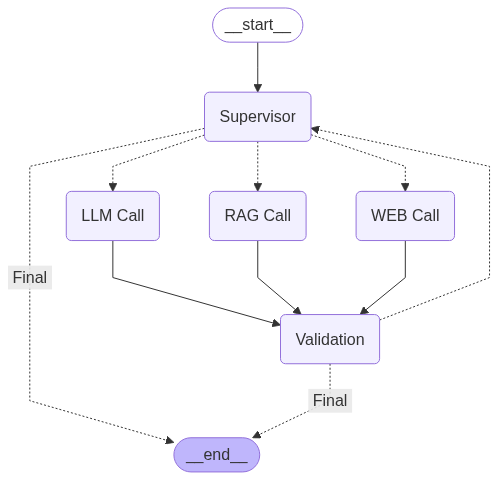

🔬 Testing Science Question (RAG Node):
🧠 Supervisor received question: What is photosynthesis?
🧭 Topic classified as: Science
🛣️ Router running...
last_message: what is photosynthesis?
🤖 LLM Node (Science Bot) running
🧠 LLM-based Validation running...
Validation result: yes
✅ Final Answer: Photosynthesis is how plants make their food!  They use sunlight, water, and air to create sugary energy and oxygen. 

🌐 Testing Current Event Question (WEB Node):
🧠 Supervisor received question: What is the latest news about Mars mission?
🧭 Topic classified as: Science
🛣️ Router running...
last_message: what is the latest news about mars mission?
🌐 -> Web Crawler (Tavily Search) Running
🧠 LLM-based Validation running...
Validation result: yes
✅ Final Answer: NASA plans Mars missions for next year, benefiting SpaceX. NASA's Perseverance rover is part of a mission to return Mars samples. China's spacecraft is collecting samples from an asteroid near Mars. 

🤖 Testing General Question (LLM Node):
🧠 Sup

In [140]:
from IPython.display import Image, display

# Display the graph visualization
display(Image(science_bot_app.get_graph().draw_mermaid_png()))

# Prepare example states for each node type
science_question = AgentState(messages=["What is photosynthesis?"], validated=False)
current_event_question = AgentState(messages=["What is the latest news about Mars mission?"], validated=False)
general_question = AgentState(messages=["Who was Albert Einstein?"], validated=False)

# Invoke the bot on each question and print the final answer

print("🔬 Testing Science Question (RAG Node):")
science_output = science_bot_app.invoke(science_question)
print("✅ Final Answer:", science_output["messages"][-1], "\n")

print("🌐 Testing Current Event Question (WEB Node):")
web_output = science_bot_app.invoke(current_event_question)
print("✅ Final Answer:", web_output["messages"][-1], "\n")

print("🤖 Testing General Question (LLM Node):")
llm_output = science_bot_app.invoke(general_question)
print("✅ Final Answer:", llm_output["messages"][-1])
